# Compute confidence interval of SRC indices using bootstrap

This examples shows how to compute SRC indices confidence bounds with bootstrap. First, we compute SRC indices and draw them. Then we compute bootstrap confidence bounds using the `BootstrapExperiment` class and draw them.

This example has been suggested as an evolution of OpenTURNS at:
https://github.com/openturns/openturns/issues/1056

In [1]:
import openturns as ot
import openturns.viewer as otv
from math import sqrt
import pylab as pl

We define the function g.

In [2]:
def functionCrue8vars(X):
    Q, Ks, Zv, Zm, Hd, Zb, L, B = X
    Zd = Zb + Hd
    alpha = (Zm - Zv) / L
    H = (Q / (Ks * B * sqrt(alpha))) ** (3.0 / 5.0)
    Zc = H + Zv
    S = Zc - Zd
    return [S]


g = ot.PythonFunction(8, 1, functionCrue8vars)
g.setDescription(["Q", "Ks", "Zv", "Zm", "Hd", "Zb", "L", "B", "S"])

Hd = 8.0
Zb = 55.5
L = 5000.0
B = 300.0
X = [Hd, Zb, L, B]
g_parametric = ot.ParametricFunction(g, [4, 5, 6, 7], X)

Then we define the random vector. 

In [3]:
Q = ot.Gumbel(558.0, 1013.0)
otLOW = ot.TruncatedDistribution.LOWER
Q = ot.TruncatedDistribution(Q, 0, otLOW)
Ks = ot.Normal(30.0, 7.5)
Ks = ot.TruncatedDistribution(Ks, 0, otLOW)
Zv = ot.Uniform(49.0, 51.0)
Zm = ot.Uniform(54.0, 56.0)

X = ot.ComposedDistribution([Q, Ks, Zv, Zm])

We produce a pair of input and output sample.

In [4]:
sampleSize = 100
sampleX = X.getSample(sampleSize)
sampleY = g_parametric(sampleX)

importance_factors = ot.CorrelationAnalysis.SRC(sampleX, sampleY)
print(importance_factors)

[0.378122,0.159565,0.180492,0.00565251]


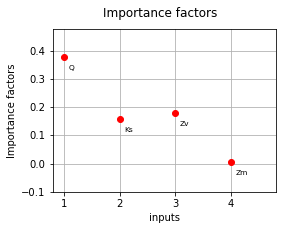

In [5]:
input_names = g_parametric.getInputDescription()
graph = ot.SobolIndicesAlgorithm.DrawCorrelationCoefficients(
    importance_factors, input_names, "Importance factors"
)
graph.setYTitle("Importance factors")
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})
_ = pl.ylim(top = 0.1 + max(importance_factors))

We now compute bootstrap confidence intervals for the importance factors. This is done with the `BootstrapExperiment` class. 

In [6]:
# Create a sample with (X,Y)
dim = sampleX.getDimension()
fullSample = ot.Sample(sampleSize, dim + 1)
fullSample[:, 0:dim] = sampleX
fullSample[:, dim] = sampleY

# Create SRC bootstrap sample
bootstrapSize = 100
importance_factors_bootstrap = ot.Sample(bootstrapSize, dim)
bootstrap = ot.BootstrapExperiment(fullSample)
for i in range(bootstrapSize):
    fullSample_boostrap = bootstrap.generate()
    sampleX_boostrap = fullSample_boostrap[:, 0:dim]
    sampleY_boostrap = fullSample_boostrap[:, dim]
    importance_factors_bootstrap[i, :] = ot.CorrelationAnalysis.SRC(sampleX_boostrap, sampleY_boostrap)

# Compute bootstrap quantiles
alpha = 0.05
importance_factors_lower_bound = importance_factors_bootstrap.computeQuantilePerComponent(alpha / 2.0)
importance_factors_upper_bound = importance_factors_bootstrap.computeQuantilePerComponent(1.0 - alpha / 2.0)
importance_factors_bounds = ot.Interval(importance_factors_lower_bound, importance_factors_upper_bound)
print(importance_factors_bounds)

[0.279526, 0.471558]
[0.0933866, 0.292377]
[0.117489, 0.27868]
[0.00126018, 0.0141868]


In [7]:
def plot_importance_factors_with_bounds(
    importance_factors, input_names, alpha, importance_bounds
):
    """
    Plot importance factors indices with confidence bounds of level 1 - alpha
    
    Parameters
    ----------
    importance_factors : ot.Point(dimension)
        The importance factors.
    input_names : list(str)
        The names of the input variables.
    alpha : float, in [0, 1]
        The complementary confidence level.
    importance_bounds : ot.Interval(dimension)
        The lower and upper bounds of the importance factors
    
    Returns
    -------
    graph : ot.Graph
        The importance factors indices with lower and upper 1-alpha confidence intervals.
    """
    dim = importance_factors.getDimension()
    lowerBounds = importance_bounds.getLowerBound()
    upperBounds = importance_bounds.getUpperBound()
    graph = ot.SobolIndicesAlgorithm.DrawCorrelationCoefficients(
        importance_factors, input_names, "Importance factors"
    )
    graph.setYTitle("Importance factors")
    title = "Importance factors with bounds at %.2f %%" % ((1 - alpha) * 100)

    graph.setTitle(title)
    # Add confidence bounds
    for i in range(dim):
        curve = ot.Curve([1 + i, 1 + i], [lowerBounds[i], upperBounds[i]])
        graph.add(curve)
    return graph

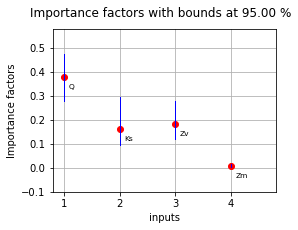

In [9]:
graph = plot_importance_factors_with_bounds(importance_factors, input_names, alpha, importance_factors_bounds)
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})
_ = pl.ylim(top = 0.2 + max(importance_factors))

We see that the variable $Q$ must be significant, because the lower bound of the confidence interval does not cross the X axis. Furthermore, its bounds are significantly greater than the bounds of the other variables (although perhaps less significantly for the $K_s$ variable). Hence, it must be recognized that $Q$ is the most important variable in this model, according to the linear regression model. 

We see that the variable $Z_m$ has a importance factor close to zero, taking into account the confidence bounds (which are very small in this case). Hence, the variable $Z_m$ could be replaced by a constant without reducing much the variance of the output. 

The variables $K_s$ and $Z_v$ are somewhat in-between these two extreme situations. We cannot state that one of them is of greater importance than the other, because the confidence bounds are of comparable magnitude. Looking uniquely at the importance factors, we may wrongly conclude that $Z_v$ has a greater impact than $K_s$ because the estimate of the importance factor for $Z_v$ is strictly greater than the estimate for $K_s$. But taking into account for the variability of the estimators, this conclusion has not foundation, since confidence limits are comparable. In order to distinguish between the impact of these two variables, a larger sample size is needed.